In [ ]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (8.0, 10.0)

In [ ]:
%load_ext autoreload
%autoreload 2



In [6]:
img_num = 30000

In [7]:
class DataGenerator(object):
    def __init__(self, annFile, dataDir):
        self._annFile = annFile
        self._dataDir = dataDir
        self._coco = COCO(annFile)
        
    def getBatch(self, n=100, imgIds=None, expandMasks=False):
        if imgIds is None:
            ids = self._coco.getImgIds()
            imgIds = ids[:n]
        
        imgs = self._coco.loadImgs(ids=imgIds)

        images = []
        labels = []
        for img in imgs:
            I = io.imread('{}/{}'.format(dataDir, img['file_name']))
            images.append(np.moveaxis(I, -1, 0))
            annIds = self._coco.getAnnIds(imgIds=img['id'])
            anns = self._coco.loadAnns(annIds)
            if expandMasks:
                res = np.zeros((max(self._coco.getCatIds()) + 1,
                                I.shape[0], I.shape[1]))
                for ann in anns:
                    mask = self._coco.annToMask(ann)
                    res[ann['category_id']] = np.where(
                        mask != 0,
                        mask,
                        res[ann['category_id']])

                labels.append(res)
            else:
                res = np.zeros((I.shape[0], I.shape[1]), dtype=np.int32)
                for ann in anns:
                    mask = self._coco.annToMask(ann) * ann['category_id']
                    res = np.where(
                        mask != 0,
                        mask,
                        res[ann['category_id']]
                    )
                labels.append(res)

        return images, labels
        

In [8]:
annFile = 'annotations/instances_train2017.json'
dataDir = 'train2017'

In [9]:
gen = DataGenerator(annFile, dataDir)

loading annotations into memory...
Done (t=18.38s)
creating index...
index created!


In [10]:
images, labels = gen.getBatch(100, expandMasks=True)
labels[0].shape

(91, 427, 640)

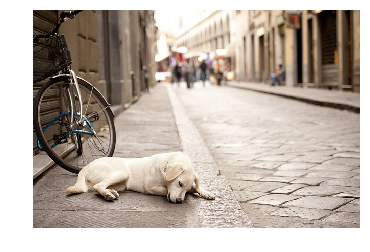

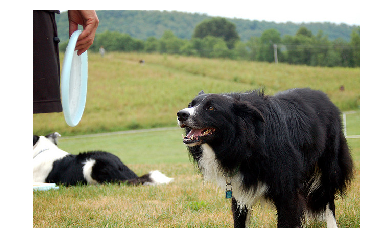

In [11]:
content = images[43]
style = images[2]
#content = images[48]
#style = images[16]
plt.figure(1)
plt.axis('off')
plt.imshow(np.moveaxis(content, 0, -1))

plt.figure(2)
plt.axis('off')

plt.imshow(np.moveaxis(style, 0, -1))
plt.show()

content_masks = labels[43]
style_masks = labels[2]
#content_masks = labels[48]
#style_masks = labels[16]

del labels
del images
del gen

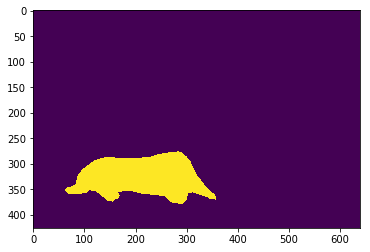

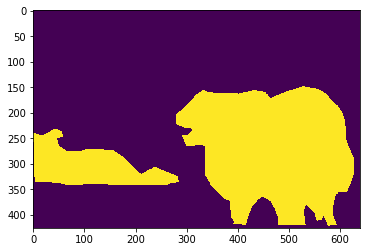

In [12]:
plt.figure(1)
plt.imshow(content_masks[18])
plt.show()

plt.figure(2)
plt.imshow(style_masks[18])
plt.show()

In [13]:
content_masks = content_masks[[0, 18]]
style_masks = style_masks[[0, 18]]

content_masks[0] = 1 - content_masks[1]
style_masks[0] = 1 - style_masks[1]

In [14]:
content_masks.shape

(2, 426, 640)

In [15]:
from torch import nn
from torch.autograd import Variable
import torch
from torchvision import transforms
from PIL import Image
from torchvision.models import vgg19, vgg19_bn
from torch.nn.functional import conv3d
import itertools
from torch import optim

In [16]:
class VGGExtractor(nn.Module):
        def __init__(self, use_cuda=True):
            super().__init__()
            model = vgg19_bn(pretrained=True)
            if torch.cuda.is_available() and use_cuda:
                model = model.cuda()

            self.first = nn.Sequential(*[model.features[i] for i in range(17)])
            self.second = nn.Sequential(*[model.features[i] for i in range(17, 30)])

            for param in model.parameters():
                param.requires_grad = False

        def forward(self, x):
            conv3_1 = self.first.forward(x)
            conv4_1 = self.second.forward(conv3_1)
            return conv3_1, conv4_1
    
vgg = VGGExtractor()

In [40]:
def get_patch(x, j, k, T):
    return x[0, :, j: T + j, k : k + T]

def extract_patches(x, newH, newW, T):
    return torch.cat([get_patch(x, i, j, T).unsqueeze(0) for i, j in itertools.product(range(newH), range(newW))], dim=0)


def preprocess_masks(content_masks, style_masks, H, W, T):
    newH, newW = H - T + 1, W - T + 1
    
    style_patches = extract_patches(style_masks, newH, newW, T)
    
    norm = (style_patches ** 2).view(style_patches.shape[0], -1).sum(1)

    return conv3d(content_masks.unsqueeze(0), style_patches.unsqueeze(1)), norm

def adjust_lr(optimizer, init_lr, decay, epoch):
    lr = init_lr * (decay ** (epoch // 100))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
def normalize(tensor):
    dist = torch.max(tensor) - torch.min(tensor)
    sz = tensor.view(-1).shape[0]
    delta =  0.5 * dist / sz 
    print(delta)
    
    return (tensor - torch.min(tensor) + delta) / (dist + 2 * delta)
                                
def extract_layer_masks(initial_masks, h, w, beta, use_cuda=True):
    if torch.cuda.is_available and use_cuda:
        return Variable(beta * downsample(torch.FloatTensor(initial_masks), (h, w)).cuda(), requires_grad=False)
    else:
        return Variable(beta * downsample(torch.FloatTensor(initial_masks), (h, w)), requires_grad=False)

def downsample(imgs, sz):
    """Downsample a sequence of binary images to a given size."""
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(sz),
        transforms.ToTensor(),
    ])
    
    return torch.cat([transform(x.view((1, *x.shape))).view((1, 1, *sz)) for x in imgs], dim=1)

def prepare_img(img, requires_grad=False, use_cuda=True, resize=None):
    if not torch.is_tensor(img):
        tens = torch.from_numpy(img) # PIL Image inverts tensor for some reason
    else:
        tens = img
    
    if resize is not None:
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(resize),
            transforms.ToTensor(),
        ])

        tens = transform(tens)

    if torch.cuda.is_available() and use_cuda:
        return Variable(tens.unsqueeze(0).cuda(), requires_grad=requires_grad)
    else:
        return Variable(tens.unsqueeze(0), requires_grad=requires_grad)

class StyleTransfer(object):
    def __init__(self, vgg=None):
        if vgg is None:
            vgg = VGGExtractor()
        self.nn = vgg
        print(self.nn.first)
        print(self.nn.second)
        
    def get_style_loss(self, content_masks, style_masks, gen_layer, style_layer, masks_product, masks_norm, T):
        EPS = 1e-8 # constant for numerical stability 
        
        _, _, H, W = style_layer.shape
        newH, newW = H - T + 1, W - T + 1

        p_s = extract_patches(style_layer, newH, newW, T)
        norm = ((p_s ** 2).view(p_s.shape[0], -1).sum() + masks_norm) ** 0.5

        norm = norm.unsqueeze(0)
        for i in range(len(masks_product.shape) - 2):
            norm = norm.unsqueeze(-1)

        feature_product = conv3d(gen_layer.unsqueeze(0), p_s.unsqueeze(1))

        NN = torch.max((feature_product + masks_product) / (norm + EPS), 1)[1]

        s = torch.cat((style_layer, style_masks), dim=1)
        p_s = extract_patches(s, newH, newW, T)

        g = torch.cat((gen_layer, content_masks), dim=1)
        p_g = extract_patches(g, newH, newW, T)
        
        #print(gen_layer.shape, style_layer.shape)
        #print("NN" ,NN.shape)
        #print("p_s, p_g", p_s.shape, p_g.shape)
        p_s = p_s[NN.view(-1)]
        
        
        
        if self.i % 100 == 0:
            self.debug['NN'].append(NN.data.cpu())
        # self.debug['feature_product'].append(feature_product.data.cpu())
        
        return ((p_g - p_s) ** 2).sum()    
    
        
    def generate(self, gen_img, content, style, content_masks, style_masks, lr, decay, n_iter, sz=None):
        if sz is None:
            h, w = content.shape[-2:]
        else:
            h, w = sz
        
        # Initialize generated image
        
        if gen_img is None:
            gen_img = np.random.randint(0, 255, content.shape, dtype=np.uint8)
            gen_var = prepare_img(gen_img, requires_grad=True, resize=(h, w))
        else:
            gen_var = prepare_img(gen_img, requires_grad=True, resize=(h, w))

        cont_var = prepare_img(content, resize=(h, w))
        style_var = prepare_img(style, resize=(h, w))
        
        style3_1, style4_1 = self.nn.forward(style_var)
        cont3_1, cont4_1 = self.nn.forward(cont_var)
        
        # set model parameters
        
        ALPHA_1 = 0
        ALPHA_2 = 2e-4
        ALPHA_3 = 1e-3

        BETA = 8

        T = 3
        
        
        # produce masks for augmented layers
        
        content_masks_0 = extract_layer_masks(content_masks, h, w, BETA)
        
        h, w = style3_1.shape[2:]

        content_masks_3_1 = extract_layer_masks(content_masks, h, w, BETA)
        style_masks_3_1 = extract_layer_masks(style_masks, h, w, BETA)
        masks_prod_3_1, masks_norm_3_1 = preprocess_masks(content_masks_3_1, style_masks_3_1, h, w, T)


        h, w = style4_1.shape[2:]
        content_masks_4_1 = extract_layer_masks(content_masks, h, w, BETA)
        style_masks_4_1 = extract_layer_masks(style_masks, h, w, BETA)
        masks_prod_4_1, masks_norm_4_1 = preprocess_masks(content_masks_4_1, style_masks_4_1, h, w, T)

        # initialize optimizer
        
        optimizer = optim.Adam([gen_var])
        
        ### initialize debug info
        
        self.debug = {}
        self.debug['loss'] = []
        self.debug['content_loss'] = []
        self.debug['style_loss_3_1'] = []
        self.debug['style_loss_4_1'] = []
        #self.debug['NN'] = []
        #self.debug['feature_product'] = []
        self.debug['mask_product'] = [masks_prod_3_1.data.cpu(), masks_prod_4_1.data.cpu()]
        self.debug['NN'] = []

        for self.i in range(n_iter):
            i = self.i
            
            adjust_lr(optimizer, lr, decay, i)

            optimizer.zero_grad()
            
            gen3_1, gen4_1 = self.nn.forward(gen_var)

            style_loss_3_1 = self.get_style_loss(content_masks_3_1, style_masks_3_1, gen3_1, style3_1,
                                            masks_prod_3_1, masks_norm_3_1, T)
            style_loss_4_1 = self.get_style_loss(content_masks_4_1, style_masks_4_1, gen4_1, style4_1,
                                            masks_prod_4_1, masks_norm_4_1, T)

            content_loss = ((cont3_1 - gen3_1) ** 2).sum() + ((cont4_1 - gen4_1) ** 2).sum()

            background_loss = ((content_masks_0[0, 0] * (cont_var - gen_var)) ** 2).sum()

            loss = ALPHA_1 * content_loss + ALPHA_2 * (style_loss_4_1 + style_loss_3_1) + ALPHA_3 * background_loss

            self.debug['loss'].append(loss.data[0])
            self.debug['content_loss'].append(content_loss.data[0])
            self.debug['style_loss_3_1'].append(style_loss_3_1.data[0])
            self.debug['style_loss_4_1'].append(style_loss_4_1.data[0])
            
            
            
            if i % 200 == 0:
                print("Iteration:", i, "Loss:", loss.data[0])
                print("Content Loss:", content_loss.data[0]* ALPHA_1)
                print("Style Loss 3_1:", style_loss_3_1.data[0] * ALPHA_2)
                print("Style Loss 4_1:", style_loss_4_1.data[0] * ALPHA_2)
                print("Background Loss:", background_loss.data[0] * ALPHA_3)
                
            loss.backward()
            
            optimizer.step()
            

        return gen_var.data.cpu()


    
    

In [41]:
trans = StyleTransfer(vgg=vgg)
    

Sequential(
  (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (7): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (14): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
)
Sequential(
  (0): Conv2d (256, 256, kernel_size=(3, 3

In [42]:
%%time
gen_img = trans.generate(
    gen_img=None,
    content=content,
    style=style,
    content_masks=content_masks,
    style_masks=style_masks,
    lr=8e-4,
    decay=0.8,
    n_iter=801,
    sz=(128, 128)
)

Iteration: 0 Loss: 244.2666015625
Content Loss: 0.0
Style Loss 3_1: 11.6882140625
Style Loss 4_1: 3.5131914062500003
Background Loss: 229.0651875
Iteration: 200 Loss: 101.6055679321289
Content Loss: 0.0
Style Loss 3_1: 8.57924765625
Style Loss 4_1: 2.6270757812500003
Background Loss: 90.39924218750001
Iteration: 400 Loss: 58.19024658203125
Content Loss: 0.0
Style Loss 3_1: 8.178996093750001
Style Loss 4_1: 2.5485126953125
Background Loss: 47.462734375000004
Iteration: 600 Loss: 40.963592529296875
Content Loss: 0.0
Style Loss 3_1: 7.9683375000000005
Style Loss 4_1: 2.5407783203125
Background Loss: 30.454476562500002
Iteration: 800 Loss: 32.8939208984375
Content Loss: 0.0
Style Loss 3_1: 7.8952156250000005
Style Loss 4_1: 2.528429296875
Background Loss: 22.470277343750002
CPU times: user 1min 57s, sys: 1.62 s, total: 1min 58s
Wall time: 1min 58s


In [43]:
from torchvision import utils
def to_img(tensor):
    """ stolen from utils.save_image"""
    grid = utils.make_grid(tensor)
    return grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()

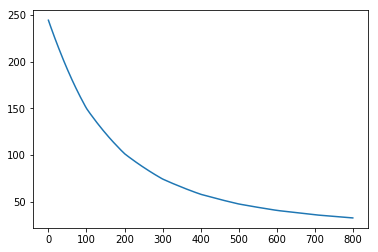

In [47]:
losses = trans.debug['loss']
plt.figure(1)
plt.plot(range(len(losses)), losses)

utils.save_image(gen_img[0], 'output/output%d.jpg' % img_num)

img_num += 1

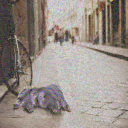

In [48]:
transforms.ToPILImage()(to_img(gen_img1[0]))

In [45]:
gen_img = gen_img1

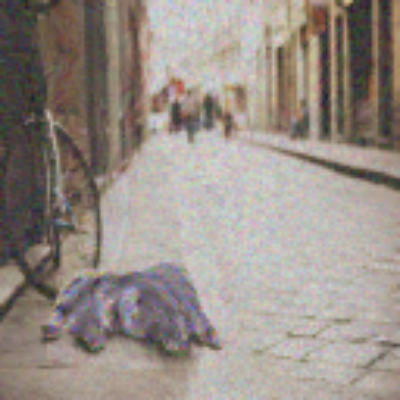

In [49]:
transforms.ToPILImage()(prepare_img(gen_img[0], use_cuda=False, resize=(400, 400))[0].data)

In [25]:
%%time
gen_img = trans.generate(
    gen_img=torch.from_numpy(to_img(gen_img[0])).permute(2, 0, 1),
    content=content,
    style=style,
    content_masks=content_masks,
    style_masks=style_masks,
    lr=6e-4,
    decay=0.8,
    n_iter=2001,
    sz=(128, 128)
)

NameError: name 'gen_img' is not defined

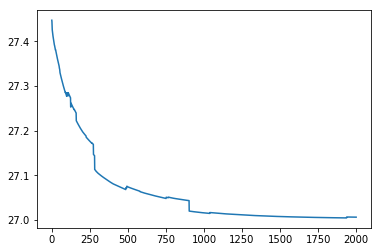

In [277]:
losses = trans.debug['loss']
plt.figure(1)
plt.plot(range(len(losses)), losses)
transforms.ToPILImage()(to_img(gen_img[0]))
utils.save_image(gen_img[0], 'output/output%d.jpg' % img_num)
img_num += 1


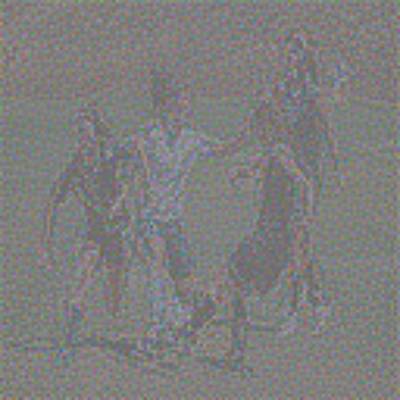

In [278]:
transforms.ToPILImage()(prepare_img(gen_img[0], use_cuda=False, resize=(400, 400))[0].data)

In [50]:
%%time
gen_img = trans.generate(
    gen_img=torch.from_numpy(to_img(gen_img[0])).permute(2, 0, 1),
    content=content,
    style=style,
    content_masks=content_masks,
    style_masks=style_masks,
    lr=1e-3,
    decay=0.8,
    n_iter=401,
    sz=(256, 256)
)

Iteration: 0 Loss: 186.61419677734375
Content Loss: 0.0
Style Loss 3_1: 55.5544
Style Loss 4_1: 17.160389062500002
Background Loss: 113.89940625
Iteration: 200 Loss: 69.50736999511719
Content Loss: 0.0
Style Loss 3_1: 41.437818750000005
Style Loss 4_1: 13.09883046875
Background Loss: 14.970720703125
Iteration: 400 Loss: 60.4819221496582
Content Loss: 0.0
Style Loss 3_1: 40.583915625
Style Loss 4_1: 12.9720375
Background Loss: 6.92597021484375
CPU times: user 5min 39s, sys: 23.7 s, total: 6min 3s
Wall time: 6min 3s


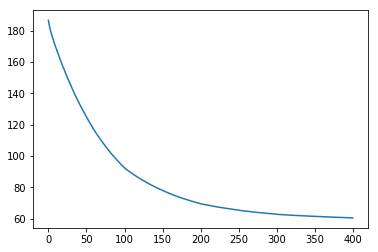

In [51]:
losses = trans.debug['loss']
transforms.ToPILImage()(to_img(gen_img[0]))

plt.figure(1)
plt.plot(range(len(losses)), losses)
plt.show()

utils.save_image(gen_img[0], 'output/output%d.jpg' % img_num)

img_num += 1

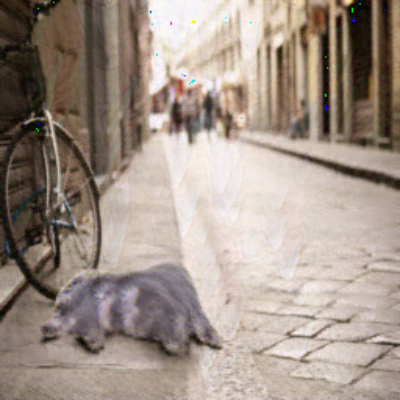

In [52]:
transforms.ToPILImage()(prepare_img(gen_img[0], use_cuda=False, resize=(400, 400))[0].data)

In [57]:
utils.save_image(prepare_img(content, use_cuda=False, resize=style.shape[-2:])[0].data, 'output/content.jpg')

In [ ]:
%%time
gen_img = trans.generate(
    gen_img=torch.from_numpy(to_img(gen_img[0])).permute(2, 0, 1),
    content=content,
    style=style,
    content_masks=content_masks,
    style_masks=style_masks,
    lr=5e-4,
    decay=0.9,
    n_iter=301,
    sz=(400, 600)
)

Iteration: 0 Loss: 409.6460266113281
Content Loss: 0.0
Style Loss 3_1: 252.94082500000002
Style Loss 4_1: 87.60798750000001
Background Loss: 69.0972265625


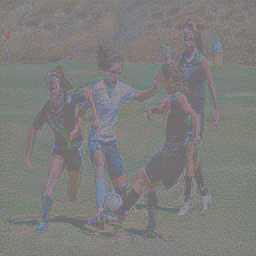

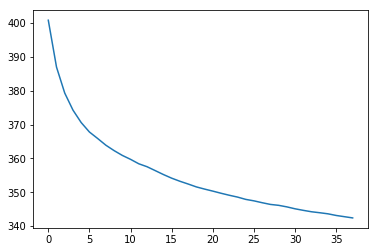

In [283]:
losses = trans.debug['loss']
plt.figure(1)
plt.plot(range(len(losses)), losses)
transforms.ToPILImage()(to_img(gen_img[0]))